In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchsummary
import torch.nn as nn
from google.colab import files
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
train_transform=transforms.Compose([transforms.RandomResizedCrop(224),transforms.ToTensor(),transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])])
test_transform=transforms.Compose([transforms.Resize(224),transforms.ToTensor(),transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])])


In [ ]:
train_data=datasets.CIFAR100(train=True,download=True,root='./data',transform=train_transform)

Files already downloaded and verified


In [ ]:
test_data=datasets.CIFAR100(train=False,download=True,root='./data',transform=test_transform)

Files already downloaded and verified


In [ ]:
classes=train_data.classes
print(len(classes))
print(classes)

100
['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tr

In [ ]:
print('Train dataset size:',len(train_data))
print('Test dataset size:',len(test_data))


Train dataset size: 50000
Test dataset size: 10000


In [ ]:
train_loader=DataLoader(train_data,batch_size=4,shuffle=True)
test_loader=DataLoader(test_data,batch_size=4,shuffle=False)

In [ ]:
def show_imgs(imgs,title):
  imgs=imgs.cpu()
  mean=torch.tensor([0.485,0.456,0.406]).view(1,3,1,1)
  std=torch.tensor([0.229,0.224,0.225]).view(1,3,1,1)
  imgs=imgs*std+mean
  img_grid=torchvision.utils.make_grid(imgs,nrow=4)
  img_np=img_grid.numpy()
  img_np=np.transpose(img_np,(1,2,0))
  plt.figure(figsize=(8,4))
  plt.imshow(img_np)
  plt.title(title)
  plt.show()

Training Examples:


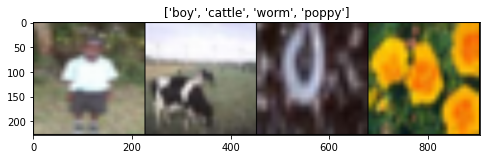

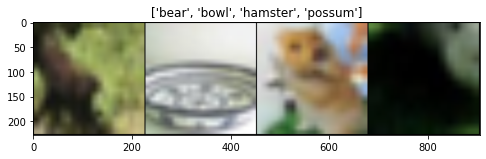

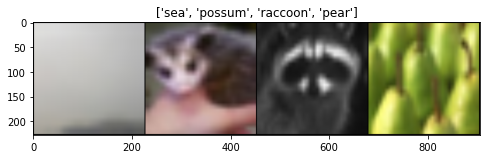

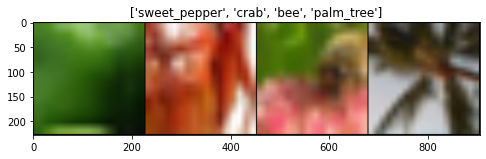

In [ ]:
print('Training Examples:')
for i,batch in enumerate(train_loader):
  if i == 4:
    break
  images,labels=batch
  show_imgs(images,str([classes[i] for i in labels]))

Test Examples:


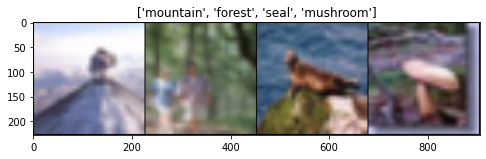

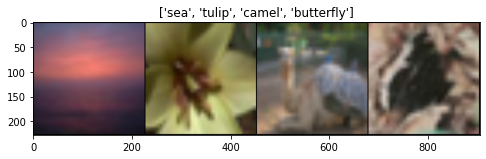

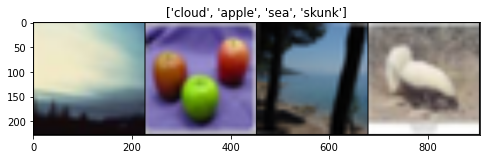

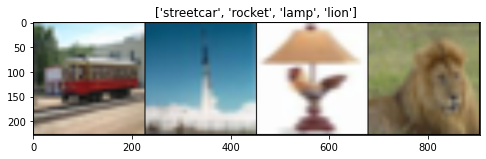

In [ ]:
print('Test Examples:')
for i,batch in enumerate(test_loader):
  if i == 4:
    break
  images,labels=batch
  show_imgs(images,str([classes[i] for i in labels]))

In [ ]:
resnet=torchvision.models.resnet18(pretrained=True)
resnet

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
for param in resnet.parameters():
  param.requires_grad=False

In [ ]:
for param in resnet.fc.parameters():
  param.requires_grad=True

In [ ]:
for param in resnet.parameters():
  if param.requires_grad==True:
    print(param.size())

torch.Size([1000, 512])
torch.Size([1000])


In [ ]:
def evaluate(model,dataloader):
  total,correct=0,0
  model.eval()
  for batch in dataloader:
    images,labels=batch
    images,labels=images.to(device),labels.to(device)
    outs=model(images)
    out_labels=torch.argmax(outs,axis=1)
    total+=labels.size(0)
    correct+=(labels==out_labels).sum().item()
  return 100*correct/total

In [ ]:
import copy
def train(model,modelname,loss_fn,optimizer,train_loader,test_loader,epochs):
  hist={'epoch_loss':[],'train_acc':[],'test_acc':[]}
  min_loss =10000
  for epoch in tqdm(range(1,epochs+1),total=epochs,desc='Training last layer'):
    losses=[]
    for batch in train_loader:
      images,labels=batch
      images,labels=images.to(device),labels.to(device)
      model.train()
      outs=model(images)
      loss=loss_fn(outs,labels)
      losses.append(loss.item())
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      del images,labels,outs
      torch.cuda.empty_cache()
    curr_epoch_loss=np.array(losses).mean()
    hist['epoch_loss'].append(curr_epoch_loss)
    hist['train_acc'].append(evaluate(model,train_loader))
    hist['test_acc'].append(evaluate(model,test_loader))
    if curr_epoch_loss<min_loss:
      min_loss=curr_epoch_loss
      best_model=copy.deepcopy(model.state_dict())
  fig,ax=plt.subplots(ncols=2,figsize=(12,6))
  ax[0].plot(range(1,epochs+1),hist['epoch_loss'],label='Loss')
  ax[0].plot(range(1,epochs+1),np.ones(epochs)*min_loss,'r--',alpha=0.6,label='Min Loss={}'.format(min_loss))
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Loss')
  ax[0].set_title('Epoch vs Loss')
  ax[0].grid()
  ax[0].legend()
  ax[1].plot(range(1,epochs+1),hist['train_acc'],'b--',alpha=0.8,label='Train Accuracy')
  ax[1].plot(range(1,epochs+1),hist['test_acc'],'r--',alpha=0.8,label='Test Accuracy')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Accuracy Score')
  ax[1].grid()
  ax[1].legend() 
  plt.plot()
  torch.save(best_model,'{0}_{1:4f}.pth'.format(modelname,min_loss))
  print("Best loss value:{}".format(min_loss))
  return best_model

In [ ]:
train_loader=DataLoader(train_data,batch_size=16,shuffle=True)
test_loader=DataLoader(test_data,batch_size=16,shuffle=False)


Best loss value:2.556687889633179


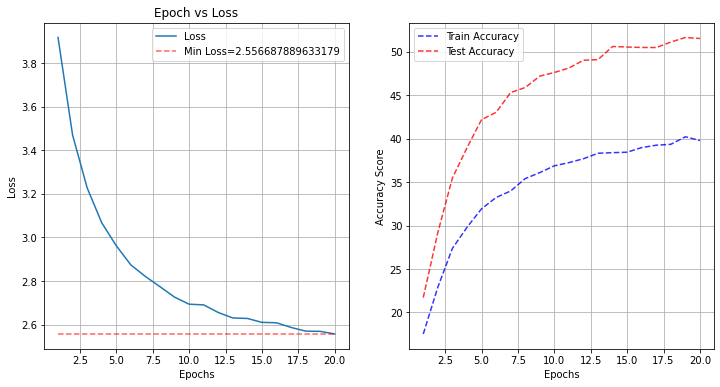

In [ ]:
resnet=resnet.to(device)
opt=torch.optim.Adam(resnet.parameters(),lr=0.0001)
loss_fn=nn.CrossEntropyLoss()
resnet_wts=train(resnet,'resnet',loss_fn,opt,train_loader,test_loader,20)

Predicted: ['spider', 'forest', 'beaver', 'mushroom', 'cloud', 'spider', 'crocodile', 'worm', 'sea', 'apple', 'palm_tree', 'trout', 'train', 'castle', 'cup', 'lion']
Actual: ['mountain', 'forest', 'seal', 'mushroom', 'sea', 'tulip', 'camel', 'butterfly', 'cloud', 'apple', 'sea', 'skunk', 'streetcar', 'rocket', 'lamp', 'lion']


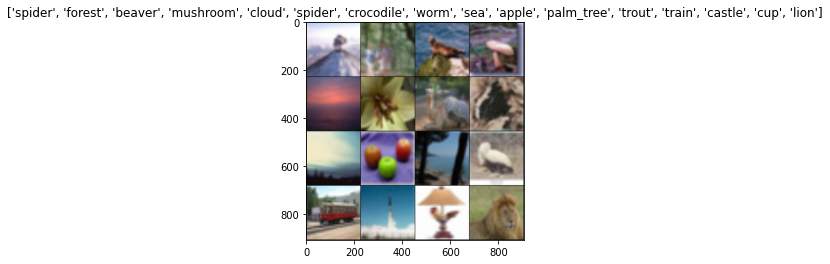

In [ ]:
test_imgs,test_lbls=next(iter(test_loader))
test_imgs,test_lbls=test_imgs.to(device),test_lbls.to(device)
out_probs=resnet(test_imgs)
out_labels=torch.argmax(out_probs,axis=1)
print('Predicted:',[classes[i] for i in out_labels])
print('Actual:',[classes[i] for i in test_lbls])
show_imgs(test_imgs,[classes[i] for i in out_labels]) 

In [ ]:
print('Test acc:',evaluate(resnet,test_loader))
print('Train acc:',evaluate(resnet,train_loader))

Test acc: 51.53
Train acc: 40.04
